## Detalle sobre este notebook (fv_democracia o autoritario):
* **OBJETIVO:** Analizar algunos aspectos **con variables bien pobladas** vinculadas a eventos reconocidos
* PERÍODO 15: 1990 a 1994
* EVENTO: luego de la caída del muro de Berlín en 1989, varios países de europa transicionan de gobiernos autoritarios (un partido) a democracias (varios partidos)

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain


#### Cargar df_5_extended

In [2]:
df_5_extended = pd.read_excel('df_5_extended.xlsx')
df_5_extended.head()

,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,15,3.113815,0.00000,1.559835,2.046771,0.331285,1.674371,4.632186,5.169904,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Albania,16,3.716797,0.00000,0.051879,3.519091,0.015910,0.579077,4.971347,1.981720,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Albania,17,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Argentina,14,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,7.595332,0.0,0.326532,0.0,0.000000,0.0,0.0,0.0,2.495280,0.0
4,Argentina,16,0.254185,0.02014,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,4.494125,0.0,0.443809,0.0,0.809128,0.0,0.0,0.0,2.573783,0.0


In [3]:
df_5_extended.shape

(1407, 144)

In [4]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [5]:
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


In [6]:
len(all_per_variables)

142

### MATRIZ DE ASPECTOS

In [7]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['Democracia_o_Gob.Autoritario_de_un_solo_partido'],
    'var_1': ['per201'],
    'var_2': ['per202'],
    'var_3': ['per2021'],  # None indica que no hay una tercera variable para el aspecto
    'var_4': [None]  
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
display(df_aspectos)

,aspecto,var_1,var_2,var_3,var_4
0,Democracia_o_Gob.Autoritario_de_un_solo_partido,per201,per202,per2021,None


#### Años en cada período

In [8]:
# cargar períodos
df_ventana_5 = pd.read_excel('data/Ventana_5.xlsx')
df_ventana_5

,agno,ventana
0,1920,1
1,1921,1
2,1922,1
3,1923,1
4,1924,1
...,...,...
99,2019,20
100,2020,21
101,2021,21
102,2022,21


#### Calculamos la similaridad tanto con correlación como con distancia euclideana

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from collections import defaultdict
import itertools


In [10]:
def calcular_similitudes_todos_paises(df, df_aspectos, tipo_similitud, periodo):
    """Calcula la similaridad entre todos los países para un aspecto específico y un período usando Pearson o Euclidean."""
    similarity_results = defaultdict(list)

    # Filtrar el dataframe para el período específico
    df = df[df['ventana_5'] == periodo]
    
    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()

        # Filtrar datos de todos los países con las columnas relevantes
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_filtered = df[columnas_relevantes].copy()

        # Calcular similitudes entre todos los pares de países
        for (idx1, row1), (idx2, row2) in itertools.combinations(df_filtered.iterrows(), 2):
            country_period_1 = f"{row1['countryname']}_{row1['ventana_5']}"
            country_data_1 = row1[variables].astype(float)

            country_period_2 = f"{row2['countryname']}_{row2['ventana_5']}"
            country_data_2 = row2[variables].astype(float)

            # Asignar similaridad de cero si uno de los países tiene todos los valores en cero
            if country_data_1.sum() == 0 or country_data_2.sum() == 0:
                similarity = 0  
            else:
                if tipo_similitud == 'pearson':
                    # Calcular la correlación de Pearson
                    corr = country_data_1.corr(country_data_2, method='pearson')
                    # print(f"Pearson/ {aspecto} / {country_period_1} / {country_period_2} / {corr}")
                    similarity = 0 if pd.isna(corr) else abs(corr)
                elif tipo_similitud == 'euclidean':
                    dist = euclidean(country_data_1, country_data_2)
                    similarity = 1 / (1 + dist) if not np.isnan(dist) else 0

            similarity_results[(aspecto, country_period_1, country_period_2)].append(similarity)

    # Convertir a DataFrame
    final_results = {
        key: np.mean(values) for key, values in similarity_results.items()
    }

    df_similarities = pd.DataFrame(
        list(final_results.items()), 
        columns=['Aspecto_Country_Period1_Period2', 'Similarity']
    )
    df_similarities[['Aspecto', 'Country_Period_1', 'Country_Period_2']] = pd.DataFrame(
        df_similarities['Aspecto_Country_Period1_Period2'].tolist(), index=df_similarities.index
    )
    df_similarities.drop('Aspecto_Country_Period1_Period2', axis=1, inplace=True)

    # Eliminar duplicados
    df_similarities = df_similarities.groupby(['Country_Period_1', 'Country_Period_2'], as_index=False).agg({'Similarity': 'mean'})
    
    return df_similarities


#### Generamos las Redes, Comunidades y Métricas de Centralidad

In [11]:
def generar_red_y_calcular_metricas(df_similarity, aspecto, tipo_similitud, porcentaje, periodo):
    """
    Genera una red de similaridad, calcula las métricas de centralidad, 
    y analiza las comunidades detectadas para un aspecto específico.
    """
    resumen = {'Aspecto': aspecto, 'Criterio': tipo_similitud}
    
    # Obtener los años "Desde" y "Hasta" para el período dado
    desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
    desde = desde_hasta_df['agno'].min()
    hasta = desde_hasta_df['agno'].max()
    
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Redondear la similaridad a 4 decimales
    df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
    
    # Crear el grafo
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])
    
    # Configuración de colores de los enlaces según la fuerza del enlace
    weights = nx.get_edge_attributes(G, 'weight').values()
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = [cm.coolwarm(norm(weight)) for weight in weights]

    # Visualización de la red de similaridad
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Red de Similitud - {aspecto}\nPeríodo {periodo} ({desde}-{hasta}) ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.show()

    # Clustering y cálculo de métricas de centralidad
    partition = community.louvain_communities(G, weight='weight')
    resumen['Num_Comunidades'] = len(partition)
    print(f"Se identificaron {resumen['Num_Comunidades']} clusters para el aspecto '{aspecto}'.")

    # Visualización del gráfico de comunidades con colores de fuerza de enlace
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    colors = cm.rainbow(np.linspace(0, 1, resumen['Num_Comunidades']))  # Colores para cada comunidad
    for i, comm in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_size=300, node_color=[colors[i]], label=f'Comunidad {i}')
    nx.draw_networkx_edges(G, pos, edge_color=[cm.coolwarm(norm(G[u][v]['weight'])) for u, v in G.edges()], width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Comunidades detectadas - {aspecto}\nPeríodo {periodo} ({desde}-{hasta}) ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.legend(loc="best")
    plt.show()

    # Identificar la comunidad de Chile
    chile_node = f"Chile_{periodo}"
    chile_community = None
    for i, comm in enumerate(partition):
        if chile_node in comm:
            chile_community = comm
            resumen['Comunidad_Chile'] = i
            resumen['Num_Paises_Chile_Comunidad'] = len(chile_community)
            print(f"Chile pertenece a la Comunidad {i}, que incluye {len(chile_community)} países:")
            print(sorted(list(chile_community)))
            break
    if not chile_community:
        resumen['Comunidad_Chile'] = None
        resumen['Num_Paises_Chile_Comunidad'] = 0

    # Listar otras comunidades
    for i, comm in enumerate(partition):
        if chile_node not in comm:
            print(f"Comunidad {i} incluye {len(comm)} países:")
            print(sorted(list(comm)))

    # Cálculo de métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    # Resumen de centralidades
    centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Closeness_Centrality': list(closeness.values()),
        'Eigenvector_Centrality': list(eigenvector.values())
    })
    
    resumen['Num_Paises'] = len(centralities)
    for metric in ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality', 'Eigenvector_Centrality']:
        resumen[f'Promedio_{metric}'] = round(centralities[metric].mean(), 4)
        resumen[f'Std_{metric}'] = round(centralities[metric].std(), 4)
        resumen[f'Max_{metric}'] = round(centralities[metric].max(), 4)

    # Mostrar centralidades ordenadas por Betweenness Centrality
    centralities_sorted = centralities.sort_values(by='Betweenness_Centrality', ascending=False)
    print("\nCentralidades ordenadas por Betweenness Centrality (de mayor a menor):")
    display(centralities_sorted[['Nodo', 'Betweenness_Centrality', 'Degree_Centrality', 'Closeness_Centrality']])

    return resumen, centralities


#### Ejecución


=== Análisis para el aspecto: Democracia_o_Gob.Autoritario_de_un_solo_partido ===



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1756/3208186923.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1756/3208186923.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


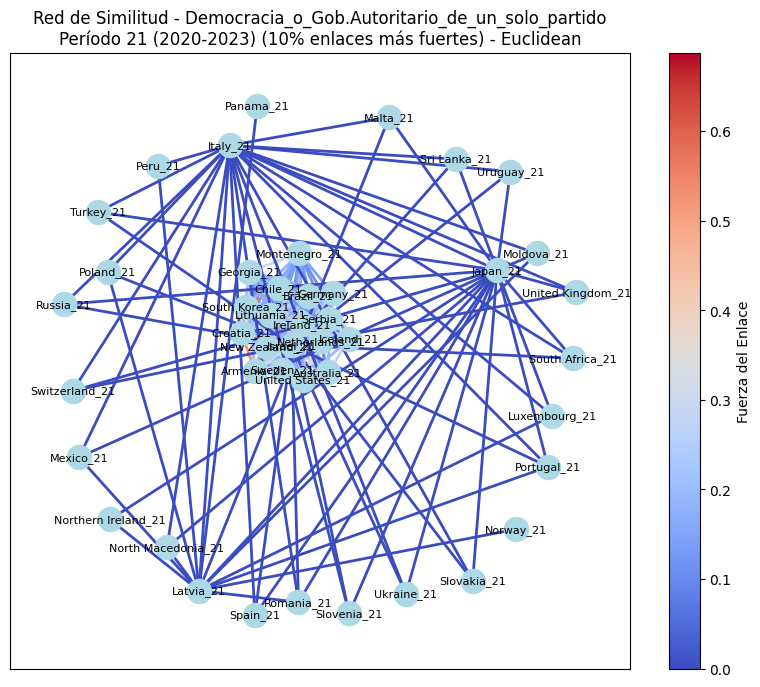

Se identificaron 29 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1756/3208186923.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


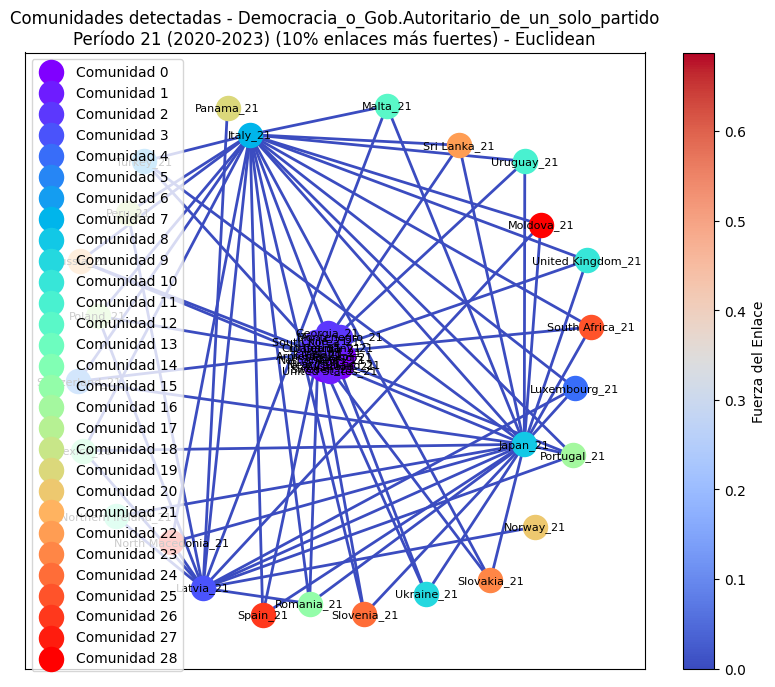

Chile pertenece a la Comunidad 2, que incluye 8 países:
['Armenia_21', 'Chile_21', 'Croatia_21', 'Georgia_21', 'Israel_21', 'Lithuania_21', 'Montenegro_21', 'South Korea_21']
Comunidad 0 incluye 6 países:
['Australia_21', 'Iceland_21', 'Ireland_21', 'New Zealand_21', 'Serbia_21', 'Sweden_21']
Comunidad 1 incluye 4 países:
['Brazil_21', 'Germany_21', 'Netherlands_21', 'United States_21']
Comunidad 3 incluye 1 países:
['Latvia_21']
Comunidad 4 incluye 1 países:
['Luxembourg_21']
Comunidad 5 incluye 1 países:
['Switzerland_21']
Comunidad 6 incluye 1 países:
['Turkey_21']
Comunidad 7 incluye 1 países:
['Italy_21']
Comunidad 8 incluye 1 países:
['Japan_21']
Comunidad 9 incluye 1 países:
['Ukraine_21']
Comunidad 10 incluye 1 países:
['United Kingdom_21']
Comunidad 11 incluye 1 países:
['Uruguay_21']
Comunidad 12 incluye 1 países:
['Malta_21']
Comunidad 13 incluye 1 países:
['Northern Ireland_21']
Comunidad 14 incluye 1 países:
['Mexico_21']
Comunidad 15 incluye 1 países:
['Romania_21']
Comun

,Nodo,Betweenness_Centrality,Degree_Centrality,Closeness_Centrality
23,Japan_21,78200.884453,0.488372,0.524390
22,Italy_21,62671.417766,0.511628,0.530864
18,Latvia_21,10848.826284,0.325581,0.483146
11,Israel_21,4262.685273,0.720930,0.671875
31,Portugal_21,0.705075,0.093023,0.524390
17,Montenegro_21,0.261356,0.395349,0.477778
30,Romania_21,0.197700,0.093023,0.524390
20,Switzerland_21,0.175906,0.069767,0.505882
36,Russia_21,0.161109,0.069767,0.505882
37,Sri Lanka_21,0.159251,0.069767,0.505882





RESUMEN DE CENTRALIDADES
ASPECTO: Democracia_o_Gob.Autoritario_de_un_solo_partido
PERÍODO: 21


,Aspecto,Criterio,Num_Comunidades,Comunidad_Chile,Num_Paises_Chile_Comunidad,Num_Paises,Promedio_Degree_Centrality,Std_Degree_Centrality,Max_Degree_Centrality,Promedio_Betweenness_Centrality,Std_Betweenness_Centrality,Max_Betweenness_Centrality,Promedio_Closeness_Centrality,Std_Closeness_Centrality,Max_Closeness_Centrality,Promedio_Eigenvector_Centrality,Std_Eigenvector_Centrality,Max_Eigenvector_Centrality
0,Democracia_o_Gob.Autoritario_de_un_solo_partido,Euclidean,29,2,8,44,0.2336,0.186,0.7209,3545.1579,14961.9316,78200.8845,0.4697,0.0666,0.6719,0.1025,0.1119,0.2471


In [12]:
# Parámetros de ejecución
periodo = 21
porcentaje = 10
pearsonsino = False  # Cambiar a False para omitir el análisis de Pearson

# Lista para almacenar los resúmenes
resumen_aspectos = []

# Iterar sobre todos los aspectos en el DataFrame df_aspectos
for aspecto in df_aspectos['aspecto']:
    print(f"\n=== Análisis para el aspecto: {aspecto} ===\n")
    
    if pearsonsino:
        # Calcular similitudes usando Pearson
        df_similarity_pearson = calcular_similitudes_todos_paises(
            df_5_extended, 
            df_aspectos[df_aspectos['aspecto'] == aspecto], 
            tipo_similitud='pearson', 
            periodo=periodo
        )
        resumen_pearson, _ = generar_red_y_calcular_metricas(
            df_similarity_pearson, 
            aspecto=aspecto, 
            tipo_similitud='Pearson', 
            porcentaje=porcentaje, 
            periodo=periodo
        )
        resumen_aspectos.append(resumen_pearson)
    
    # Calcular similitudes usando Euclidean
    df_similarity_euclidean = calcular_similitudes_todos_paises(
        df_5_extended, 
        df_aspectos[df_aspectos['aspecto'] == aspecto], 
        tipo_similitud='euclidean', 
        periodo=periodo
    )
    resumen_euclidean, _ = generar_red_y_calcular_metricas(
        df_similarity_euclidean, 
        aspecto=aspecto, 
        tipo_similitud='Euclidean', 
        porcentaje=porcentaje, 
        periodo=periodo
    )
    resumen_aspectos.append(resumen_euclidean)

# Crear el DataFrame resumen
df_resumen = pd.DataFrame(resumen_aspectos)

print("\n\n\nRESUMEN DE CENTRALIDADES")
print(f"ASPECTO: {aspecto}")
print(f"PERÍODO: {periodo}")
# Mostrar el resumen
display(df_resumen)


##### ANÁLISIS DEL ASPECTO: 'Democracia_o_Gob.Autoritario_de_un_solo_partido', EN EL PERÏODO 21: 
* Llama la atención que **Japón, Italia y Latvia** tengan un betweenness tan elevado.
* a lo anterior de debe agregar que en los datos, esos 3 países no tienen menciones en las variables per del aspecto en cuestión.
* Betweenness Centrality mide cuántos caminos más cortos pasan por un nodo, y no requiere directamente que el nodo tenga conexiones fuertes o valores significativos en sus variables. **Es una propiedad estructural del grafo**
* Lo anterior indica que esos 3 países tienen una posición estratégica en la red 
* Por último, considerando los 3 países mencionados, la intuición no indica que no deberían tener similaridad muy alta, pero dadas las conecciones en la red, otro nodos necesitan pasar a través de ellos para conectarse con comunidades separadas
* La red es bastante fragmentada (28 comunidades) y dado que se eligió considerar sólo el 10% de los enlaces más fuertes, la red claramente puede estar 'amplificando' la importancia de esos 3 nodos.

#### VEAMOS CÓMO SE DISTRIBUYEN LAS MÉTRICAS DE CENTRALIDAD PARA VER SI HAY NODOS QUE MUESTREN EXCEPCIONALIDADES


=== Distribución de centralidades para el aspecto: Democracia_o_Gob.Autoritario_de_un_solo_partido ===



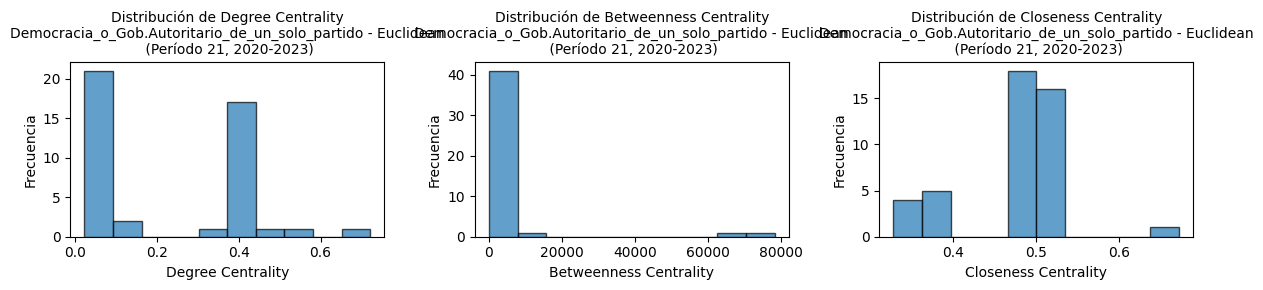

In [13]:
import matplotlib.pyplot as plt

def calcular_centralidades(df_similarity, aspecto, tipo_similitud, porcentaje, periodo):
    """
    Calcula las métricas de centralidad para un grafo construido a partir de las similitudes.
    """
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Crear el grafo
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])

    # Calcular métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    # Resumen de centralidades
    centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Closeness_Centrality': list(closeness.values()),
        'Eigenvector_Centrality': list(eigenvector.values())
    })

    return centralities


def graficar_distribucion_centralidades(df_centralities, aspecto, tipo_similitud, periodo, titulo_fontsize=10):
    """Grafica la distribución de las centralidades para un aspecto específico."""
    # Obtener los años "Desde" y "Hasta" para el período
    desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
    desde = desde_hasta_df['agno'].min()
    hasta = desde_hasta_df['agno'].max()

    metrics = ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality']
    num_metrics = len(metrics)
    
    plt.figure(figsize=(12, 3))
    for i, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, i + 1)
        plt.hist(df_centralities[metric], bins=10, edgecolor='black', alpha=0.7)
        plt.title(f'Distribución de {metric.replace("_", " ")}\n{aspecto} - {tipo_similitud}\n (Período {periodo}, {desde}-{hasta})', fontsize=titulo_fontsize)
        plt.xlabel(metric.replace("_", " "))
        plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()


# Ejecución para graficar distribuciones
for aspecto in df_aspectos['aspecto']:
    print(f"\n=== Distribución de centralidades para el aspecto: {aspecto} ===\n")
    
    if pearsonsino:
        df_similarity_pearson = calcular_similitudes_todos_paises(
            df_5_extended, 
            df_aspectos[df_aspectos['aspecto'] == aspecto], 
            tipo_similitud='pearson', 
            periodo=periodo
        )
        centralities_pearson = calcular_centralidades(
            df_similarity_pearson, 
            aspecto=aspecto, 
            tipo_similitud='Pearson', 
            porcentaje=porcentaje, 
            periodo=periodo
        )
        graficar_distribucion_centralidades(centralities_pearson, aspecto, 'Pearson', periodo, titulo_fontsize=10)
    
    df_similarity_euclidean = calcular_similitudes_todos_paises(
        df_5_extended, 
        df_aspectos[df_aspectos['aspecto'] == aspecto], 
        tipo_similitud='euclidean', 
        periodo=periodo
    )
    centralities_euclidean = calcular_centralidades(
        df_similarity_euclidean, 
        aspecto=aspecto, 
        tipo_similitud='Euclidean', 
        porcentaje=porcentaje, 
        periodo=periodo
    )
    graficar_distribucion_centralidades(centralities_euclidean, aspecto, 'Euclidean', periodo, titulo_fontsize=10)


In [14]:
df_similarity_euclidean

,Country_Period_1,Country_Period_2,Similarity
0,Albania_21,Argentina_21,0.0
1,Albania_21,Austria_21,0.0
2,Albania_21,Azerbaijan_21,0.0
3,Albania_21,Belarus_21,0.0
4,Albania_21,Belgium_21,0.0
...,...,...,...
2206,United States_21,Switzerland_21,0.0
2207,United States_21,Turkey_21,0.0
2208,United States_21,Ukraine_21,0.0
2209,United States_21,United Kingdom_21,0.0


In [15]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()

,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


#### Analicemos 'Democracia_o_Autoritario' sólo con dos variables ya que la tercera es menos informada. Chile aparece en rojo

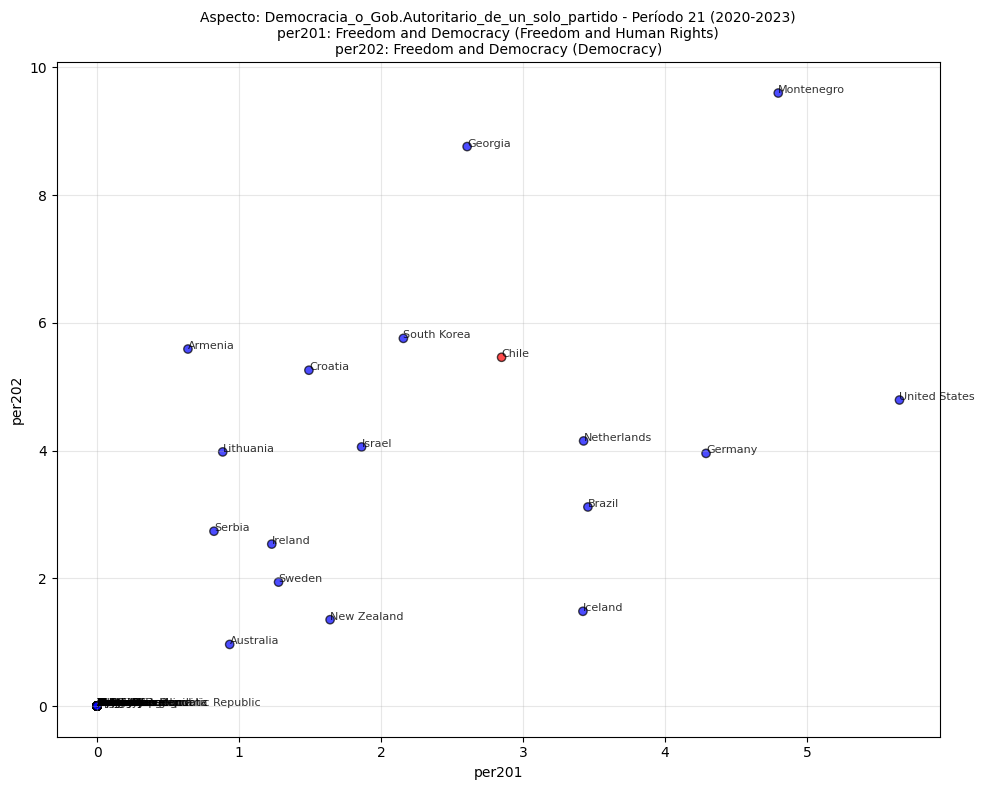

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1756/2487774468.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_data.rename(columns={'countryname': 'País'}, inplace=True)


,País,per201,per202
14,Armenia,0.6402,5.5905
30,Australia,0.9341,0.9652
79,Brazil,3.4564,3.1173
107,Chile,2.8487,5.4613
125,Croatia,1.4920,5.2587
...,...,...,...
1358,Switzerland,0.0000,0.0000
1365,Turkey,0.0000,0.0000
1380,Ukraine,0.0000,0.0000
1386,United Kingdom,0.0000,0.0000


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar las variables asociadas al aspecto 'Democracia_o_Autoritario'
aspecto_filtro = 'Democracia_o_Gob.Autoritario_de_un_solo_partido'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2']].dropna().values.flatten()

# Obtener los dominios y detalles asociados a las variables
df_variables_info = df_AD[df_AD['Variable_per'].isin(variables)][['Variable_per', 'Nombre_Dominio', 'Detalle_Dominio']]

# Crear la descripción del título con las variables y sus dominios
variables_descripcion = "\n".join([
    f"{row['Variable_per']}: {row['Nombre_Dominio']} ({row['Detalle_Dominio']})"
    for _, row in df_variables_info.iterrows()
])

# Filtrar el dataframe con las variables seleccionadas
df_filtered = df_5_extended[['countryname', 'ventana_5'] + list(variables)].copy()
df_filtered = df_filtered[df_filtered['ventana_5'] == periodo]  # Filtrar por el período deseado

# Obtener los años "Desde" y "Hasta" para el período
desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
desde = desde_hasta_df['agno'].min()
hasta = desde_hasta_df['agno'].max()

# Redondear los valores a 4 decimales
df_filtered[list(variables)] = df_filtered[list(variables)].round(4)

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 8))

# Asignar colores: rojo para Chile, azul para otros países
colors = ['red' if country == 'Chile' else 'blue' for country in df_filtered['countryname']]
plt.scatter(df_filtered[variables[0]], df_filtered[variables[1]], c=colors, alpha=0.7, edgecolor='k')

# Añadir etiquetas para los puntos
for i, row in df_filtered.iterrows():
    plt.text(row[variables[0]], row[variables[1]], row['countryname'], fontsize=8, alpha=0.8)

# Configurar título y etiquetas
plt.title(
    f'Aspecto: {aspecto_filtro} - Período {periodo} ({desde}-{hasta})\n{variables_descripcion}', 
    fontsize=10
)
plt.xlabel(variables[0].replace('_', ' '), fontsize=10)
plt.ylabel(variables[1].replace('_', ' '), fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Preparar la tabla como DataFrame filtrada por período
table_data = df_filtered[['countryname'] + list(variables)]
table_data.rename(columns={'countryname': 'País'}, inplace=True)

# Mostrar la tabla
table_data


#### Analicemos la dispersión de un aspecto descrito por 3 variables: 

In [17]:
df_aspectos

,aspecto,var_1,var_2,var_3,var_4
0,Democracia_o_Gob.Autoritario_de_un_solo_partido,per201,per202,per2021,None


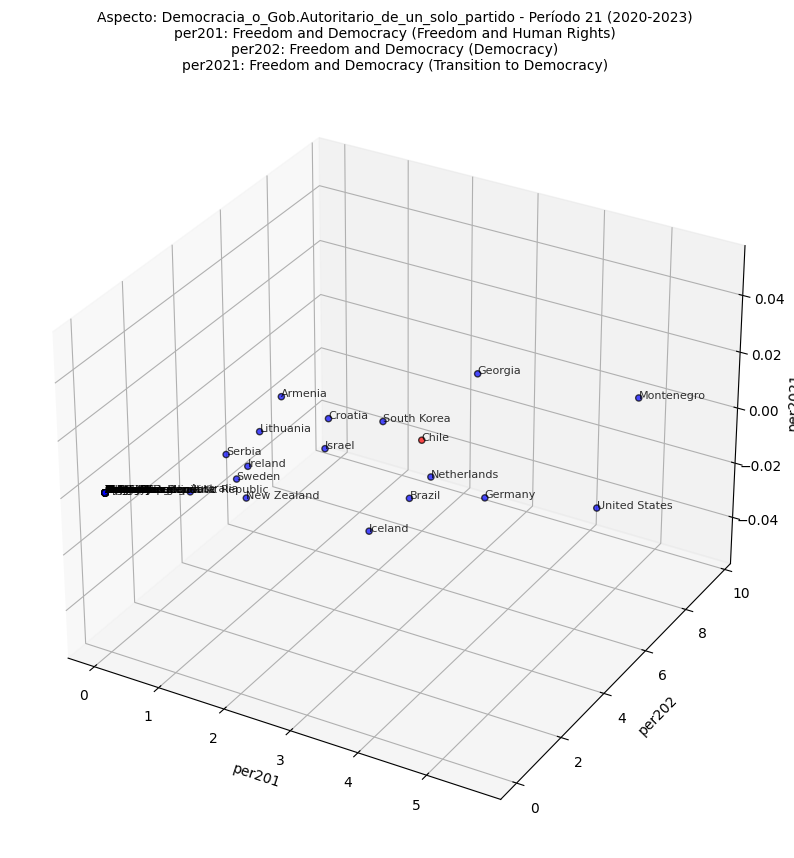

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1756/720934663.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_data.rename(columns={'countryname': 'País'}, inplace=True)


,País,per201,per202,per2021
14,Armenia,0.6402,5.5905,0.0
30,Australia,0.9341,0.9652,0.0
79,Brazil,3.4564,3.1173,0.0
107,Chile,2.8487,5.4613,0.0
125,Croatia,1.4920,5.2587,0.0
...,...,...,...,...
1358,Switzerland,0.0000,0.0000,0.0
1365,Turkey,0.0000,0.0000,0.0
1380,Ukraine,0.0000,0.0000,0.0
1386,United Kingdom,0.0000,0.0000,0.0


In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Filtrar las variables asociadas al aspecto
aspecto_filtro = 'Democracia_o_Gob.Autoritario_de_un_solo_partido'  # Cambiar al aspecto deseado
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3']].dropna().values.flatten()

# Obtener los dominios y detalles asociados a las variables
df_variables_info = df_AD[df_AD['Variable_per'].isin(variables)][['Variable_per', 'Nombre_Dominio', 'Detalle_Dominio']]

# Crear la descripción del título con las variables y sus dominios
variables_descripcion = "\n".join([
    f"{row['Variable_per']}: {row['Nombre_Dominio']} ({row['Detalle_Dominio']})"
    for _, row in df_variables_info.iterrows()
])

# Filtrar el dataframe con las variables seleccionadas
df_filtered = df_5_extended[['countryname', 'ventana_5'] + list(variables)].copy()
df_filtered = df_filtered[df_filtered['ventana_5'] == periodo]  # Filtrar por el período deseado

# Obtener los años "Desde" y "Hasta" para el período
desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
desde = desde_hasta_df['agno'].min()
hasta = desde_hasta_df['agno'].max()

# Redondear los valores a 4 decimales
df_filtered[list(variables)] = df_filtered[list(variables)].round(4)

# Crear el gráfico de dispersión 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Extraer las variables y los países
x_var = variables[0]
y_var = variables[1]
z_var = variables[2]

# Asignar colores: rojo para Chile, azul para otros países
colors = ['red' if country == 'Chile' else 'blue' for country in df_filtered['countryname']]

# Añadir puntos al gráfico
ax.scatter(
    df_filtered[x_var], 
    df_filtered[y_var], 
    df_filtered[z_var], 
    c=colors, 
    alpha=0.7, 
    edgecolor='k'
)

# Añadir etiquetas para los puntos
for i, row in df_filtered.iterrows():
    ax.text(row[x_var], row[y_var], row[z_var], row['countryname'], fontsize=8, alpha=0.8)

# Configurar el título y las etiquetas de los ejes
ax.set_title(
    f'Aspecto: {aspecto_filtro} - Período {periodo} ({desde}-{hasta})\n{variables_descripcion}', 
    fontsize=10
)
ax.set_xlabel(x_var.replace('_', ' '), fontsize=10)
ax.set_ylabel(y_var.replace('_', ' '), fontsize=10)
ax.set_zlabel(z_var.replace('_', ' '), fontsize=10)

plt.show()

# Preparar la tabla como DataFrame
table_data = df_filtered[['countryname'] + list(variables)]
table_data.rename(columns={'countryname': 'País'}, inplace=True)

# Mostrar la tabla
table_data
